In [1]:
import numpy as np
import gwpy
import bilby
from pygwb.detector import Interferometer
from pygwb.network import Network

# Inject a power spectrum in random LIGO noise

### simulation parameters

In [2]:
duration = 60
# duration of each segment of data (s)
N_segs = 10 
# number of data segments to generate
sampling_frequency = 1024
# Hz

## Injection of a broken power law 

### The signal to inject: the simulator module takes a gwpy FrequencySeries as input. We start by building a custom input signal by defining an Intensity function. 

In [3]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    #power[freqs<10.]= omegaRef * (10. / fref) ** alpha1
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

### Initialise empty interferometers and set a noise PSD to use in the simulation

In [4]:
H1 = Interferometer.get_empty_interferometer("H1")
L1 = Interferometer.get_empty_interferometer("L1")
V1 = Interferometer.get_empty_interferometer("V1")
K = Interferometer.get_empty_interferometer("K1")
G = Interferometer.get_empty_interferometer("GEO600")

ifo_list = [H1, L1, V1, K, G]

In [5]:
for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

### Initialise a network with the interferometer list

In [6]:
net_HLV = Network('HLV', ifo_list)

### Set the data in each interferometer -- this uses the simulator module

In [7]:
net_HLV.set_interferometer_data_from_simulator(N_segments=N_segs, GWB_intensity=Intensity_GW_inject, sampling_frequency=sampling_frequency)

/home/arianna.renzini/PROJECTS/pygwb_derek/pygwb/network.py:221: UserWarning: User did not specify a start time. Setting start time to zero.
  warnings.warn(
2023-01-31 15:29:55.980 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 15:29:56.057 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 15:29:56.129 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel V1:SIM-STOCH_INJ
2023-01-31 15:29:56.203 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel K1:SIM-STOCH_INJ
2023-01-31 15:29:56.276 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel GEO600:SIM-STOCH_INJ


### Visualise a minute of data

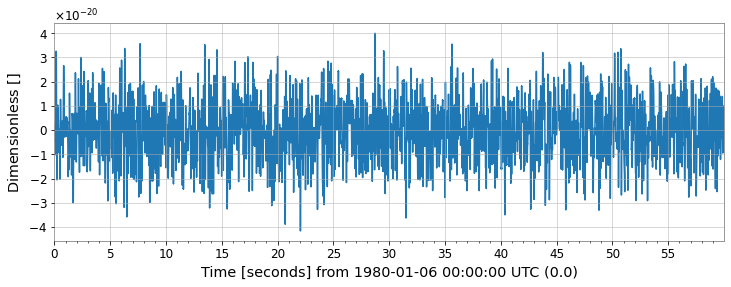

In [8]:
crop_start_time = net_HLV.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min = net_HLV.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min.plot()

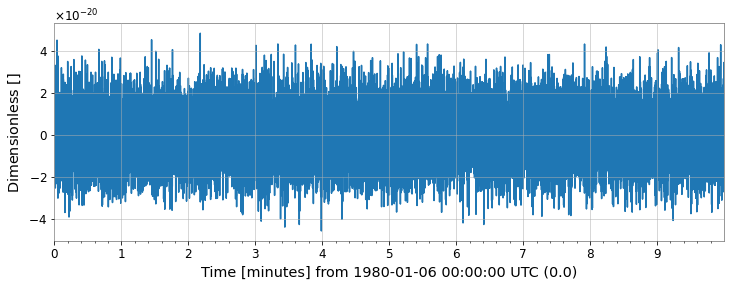

In [9]:
net_HLV.interferometers[1].strain_data.to_gwpy_timeseries().plot()

### Optional: one may save the data by calling save_interferometer_data_to_file and specifying the file format as an argument. This wraps gwpy.TimeSeries.write()

In [10]:
# net.save_interferometer_data_to_file()

### Visualize the data PSD, the injected curve and the original noise curve

Text(0, 0.5, 'PSD')

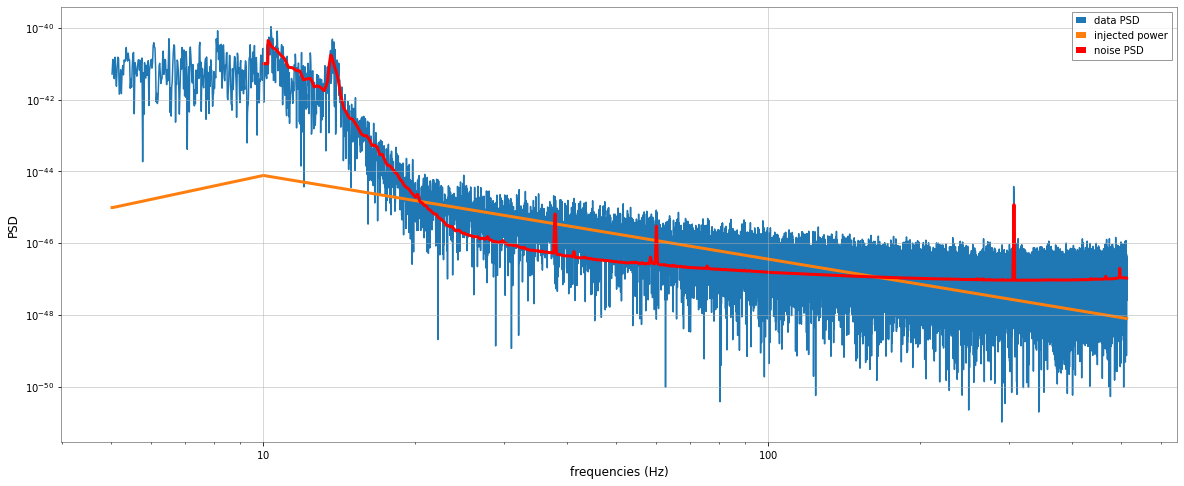

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

frequencies = data_H_1min.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min.psd().value[mask], label = 'data PSD')
plt.loglog(frequencies[mask], IntensityGW(frequencies[mask],omegaRef = omegaRef, alpha1 = alpha1, fref = fref), linewidth = 3, label = 'injected power')
plt.loglog(H1.power_spectral_density.frequency_array[H1.power_spectral_density.frequency_array>10], H1.power_spectral_density.psd_array[H1.power_spectral_density.frequency_array>10], linewidth = 3, color = 'red', label = 'noise PSD')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')